In [10]:
import pandas as pd
import src.scrape_insta
import src.clean as clean
%autoreload
import numpy as np
import re 
from selenium import webdriver
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from IPython.display import HTML
from bs4 import BeautifulSoup
import json.decoder as decoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [112]:
qualdf = pd.read_csv('soft_content.txt', sep="|")

In [113]:
urls = list(qualdf.url.unique())
pickle_in2 = open("quant_data.pkl","rb")
quant_df = pickle.load(pickle_in2)

In [114]:
combined = clean.combine_data(qualdf,quant_df)
combined2 = clean.clean_combined(combined)

# Changing columns for clustering

In [24]:
combined2['female'] = (combined2['female'] | combined2['mixed_gender'])
combined2['male'] = (combined2['male'] | combined2['mixed_gender'])
combined2['bikini'] = (combined2['bikini'] | combined2['biki+apparel'])
combined2['apparel'] = (combined2['apparel'] | combined2['biki+apparel'])

In [62]:
drop_redundency = combined2.drop(['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'hour',
       'month', 'number_of_likes','mixed_gender', 'biki+apparel', 'no_product', 'num_people_tagged'], axis=1)

In [63]:
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(drop_redundency)
sil_scores=[]

In [84]:
i=20
kmeans = KMeans(n_clusters=i)
kmeans.fit(scaled)
clustered= kmeans.predict(scaled) 
sil = silhouette_score(scaled,clustered)
print (sil)
sil_scores.append((i,sil))
scores = [tup[1] for tup in sil_scores]

0.3012527560325276


In [88]:
sil_scores
scores = [tup[1] for tup in sil_scores]

In [55]:
len(scores)+2

20

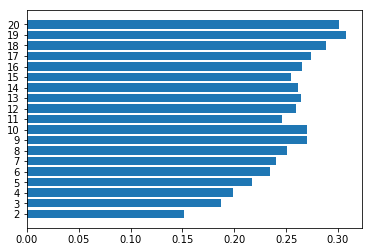

In [89]:
_=plt.barh(range(2, len(scores)+2),scores)
_=plt.yticks(range(2,len(scores)+2))

In [90]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(scaled)
clustered= kmeans.predict(scaled) 

In [106]:
(clustered).sum()

0

# with all data, Gradient Boosted Model

In [120]:
vocab, hashtag_tfidf = clean.make_hashtag_tfidf(combined)

In [121]:
combined3 = pd.concat([combined2, hashtag_tfidf], axis=1)

In [122]:
y = combined3['number_of_likes']
X = combined3.drop(['number_of_likes',], axis=1)

In [138]:
gbr = GradientBoostingRegressor(learning_rate=0.01, loss='ls',
                                min_samples_split=4, n_estimators=600,
                                max_depth=5)

In [139]:
scores = cross_val_score(gbr, X, y,cv=40, scoring= 'neg_mean_absolute_error')
print(scores.mean())
print(scores)

-47.39873085759742
[-49.838075   -34.12012204 -53.9843142  -48.58321049 -63.72727159
 -77.97460304 -43.30489597 -58.76824535 -40.20633421 -34.09746574
 -58.6871968  -36.14093648 -41.75383339 -59.80677589 -68.11078115
 -37.37500358 -35.00983749 -27.31764488 -43.37304048 -31.24419324
 -32.05144336 -35.40207187 -29.30096329 -32.88283838 -38.71303053
 -41.34173143 -49.61178419 -65.07943797 -55.39758844 -54.84723184
 -25.81548032 -49.86086603 -43.67470039 -71.57666666 -40.6638613
 -71.31276686 -75.79349753 -31.35528974 -66.46807139 -41.37613179]


In [135]:
scores = cross_val_score(gbr, X, y,cv=40, scoring= 'neg_mean_absolute_error')
print(scores.mean())
print(scores)

-46.70920500777229
[-54.48138522 -31.81324439 -50.36633968 -52.68573809 -58.21127373
 -72.55953648 -37.0740229  -51.3888506  -43.79867118 -30.31943009
 -56.88270972 -45.80547014 -50.67626939 -56.56372853 -67.05357854
 -36.97257314 -30.94725663 -35.66019022 -43.80198209 -32.47095404
 -40.75282747 -36.54770504 -26.43894449 -35.08625148 -45.09246542
 -39.02489699 -49.68799814 -65.54683539 -63.26900041 -48.25248014
 -21.68331523 -45.50784708 -39.79483085 -61.46150434 -41.75406755
 -69.43898426 -67.93290031 -26.00337208 -62.17765514 -43.38111372]


In [140]:
max_depth =[(2,47.05287822339375),(3,46.70920500777229),(4,46.05935529376886),(5,47.39873085759742)]

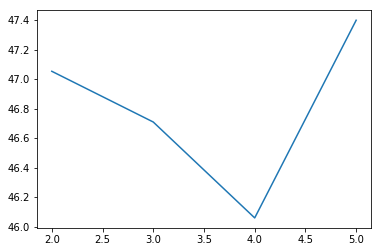

In [144]:
_=plt.plot([tup[0] for tup in max_depth],[tup[1] for tup in max_depth])

In [147]:
print(combined3['number_of_likes'].mean())
print(combined3['number_of_likes'].std())


276.02962962962965
74.50495263004379


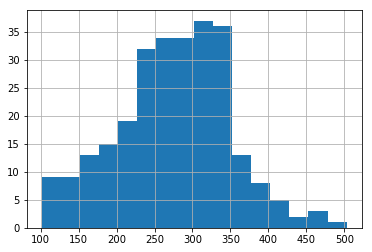

In [156]:
combined3['number_of_likes'].hist(bins=16)

In [166]:
X_train, X_test, y_train, y_test=train_test_split(X.as_matrix(), y.as_matrix(),test_size=.1)

In [169]:
gbr.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=600, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [171]:
feats=gbr.feature_importances_

In [188]:
for name, imp in zip(X.columns, feats):
    if imp > .01:
        if type(name) == int:
            name = '{}-{}'.format(name, rev_dict[name])

            print("{} : {}".format(name, round(imp,3)))

hour : 0.057
month : 0.107
num_people_tagged : 0.027
butt_pic : 0.018
pro\model : 0.02
no_product : 0.012
48-cheekybikini : 0.011
87-driftbikinis : 0.022
114-fempreneur : 0.011
134-grainisgood : 0.011
136-grassroots : 0.016
140-handmadebikini : 0.01
163-indiansummer : 0.014
208-minimalzine : 0.031
219-mytinyatlas : 0.019
225-northeastcollective : 0.015
227-nothingincommon : 0.021
236-oneofakind : 0.012
260-portraits_mf : 0.011
262-portsmouth : 0.016
263-portsmouthnh : 0.019
302-shoplocal : 0.016
366-thedriftcollective : 0.026
397-vintage : 0.015
402-vintagedenim : 0.013
403-vintagefashion : 0.015


In [296]:
only_appears_once = []
for tag in hashtag_occurances.keys():
    if hashtag_occurances[tag] == 1:
        only_appears_once.append(tag)

In [301]:
numbers_to_remove = []
for tag in only_appears_once:
    numbers_to_remove.append(vocab[tag.lower()])

In [302]:
numbers_to_remove

[244,
 240,
 115,
 355,
 28,
 360,
 321,
 350,
 352,
 413,
 295,
 398,
 395,
 311,
 71,
 313,
 392,
 393,
 268,
 197,
 315,
 284,
 290,
 235,
 168,
 167,
 275,
 209,
 23,
 196,
 177,
 351,
 384,
 16,
 56,
 210,
 382,
 427,
 332,
 10,
 410,
 408,
 330,
 280,
 283,
 409,
 211,
 65,
 102,
 308,
 50,
 145,
 19,
 133,
 334,
 318,
 387,
 99,
 285,
 165,
 47,
 258,
 25,
 192,
 286,
 193,
 312,
 333,
 394,
 124,
 35,
 57,
 41,
 375,
 80,
 319,
 108,
 42,
 220,
 37,
 89,
 234,
 72,
 146,
 399,
 53,
 54,
 302,
 34,
 340,
 81,
 149,
 7,
 379,
 249,
 101,
 178,
 5,
 155,
 305,
 297,
 217,
 74,
 43,
 224,
 373,
 238,
 335,
 254,
 2,
 253,
 162,
 239,
 267,
 269,
 251,
 11,
 76,
 195,
 181,
 6,
 154,
 119,
 61,
 20,
 316,
 12,
 383,
 299,
 21,
 376,
 270,
 293,
 354,
 153,
 73,
 296,
 88,
 150,
 199,
 363,
 250,
 75,
 407,
 248,
 105,
 106,
 189,
 24,
 343,
 78,
 31,
 107,
 164,
 227,
 60,
 310,
 327,
 347,
 121,
 256,
 125,
 137,
 255,
 153,
 127,
 128,
 271,
 272,
 287,
 86,
 328,
 144,
 109,
 95,

{'35analog': 0,
 '35mm': 1,
 '35mmfilm': 2,
 '603': 3,
 '90sfashion': 4,
 '90shiphop': 5,
 '90skids': 6,
 '90sparty': 7,
 'abikiniaday': 8,
 'accidentalzine': 9,
 'acidwash': 10,
 'acrylicpainting': 11,
 'acurrentaffair': 12,
 'analogue': 13,
 'analoguevibes': 14,
 'analogvibes': 15,
 'antiques': 16,
 'archivecollectivemag': 17,
 'artistcollaboration': 18,
 'asburypark': 19,
 'atelier': 20,
 'babetown': 21,
 'beach': 22,
 'beachwear': 23,
 'beastcoast': 24,
 'beckley': 25,
 'bestfitsdaily': 26,
 'betheadventure': 27,
 'biarritz': 28,
 'biggie': 29,
 'bikiniready': 30,
 'birthdaygirl': 31,
 'birthdayshots': 32,
 'bleachmyfilm': 33,
 'blockisland': 34,
 'boston': 35,
 'bostonblogger': 36,
 'bowie': 37,
 'broadmag': 38,
 'bubblerock': 39,
 'cactus': 40,
 'cali': 41,
 'camouflage': 42,
 'capecod': 43,
 'champagne': 44,
 'chasinglight': 45,
 'cheadsmagazine': 46,
 'cheeky': 47,
 'cheekybikini': 48,
 'cheers': 49,
 'chugandshop': 50,
 'coastallife': 51,
 'collaborationmastered': 52,
 'colora

In [228]:
imp_tags = [(48,'cheekybikini'), (87,'driftbikinis'), (114,'fempreneur' ), 
(134,'grainisgood'),(136,'grassroots'), (140,'handmadebikini'),
(163,'indiansummer'), (208,'minimalzine'), (219,'mytinyatlas'),
(225,'northeastcollective'),(227,'nothingincommon'),(236,'oneofakind'),
(260,'portraits_mf'),(262,'portsmouth' ), (263,'portsmouthnh'),
(302,'shoplocal'),(366,'thedriftcollective'),(397,'vintage'),
(402,'vintagedenim'),(403,'vintagefashion')]

In [235]:
likes_data={}
for num, tag in zip([tup[0] for tup in imp_tags],[tup[1] for tup in imp_tags]):
    likes_data[tag] = (hashtag_occurances[tag], combined3[combined3[num] >0].number_of_likes.mean(), combined3[combined3[num] >0].number_of_likes.std())

In [236]:
likes_data

{'cheekybikini': (8, 264.85714285714283, 66.81923019467916),
 'driftbikinis': (32, 297.65625, 94.88791669054056),
 'fempreneur': (12, 234.91666666666666, 83.17938810823632),
 'grainisgood': (135, 263.5777777777778, 70.5737115094488),
 'grassroots': (9, 310.3333333333333, 92.28488500290824),
 'handmadebikini': (10, 300.3, 33.07247932781709),
 'indiansummer': (2, 151.5, 60.10407640085654),
 'minimalzine': (180, 278.3820224719101, 74.19816277104415),
 'mytinyatlas': (43, 282.7906976744186, 64.87958008037987),
 'northeastcollective': (5, 166.2, 49.2767693746252),
 'nothingincommon': (31, 310.15625, 66.50399424094766),
 'oneofakind': (1, 202.0, nan),
 'portraits_mf': (12, 333.0, 73.63546576332507),
 'portsmouth': (14, 318.92857142857144, 65.60893968837605),
 'portsmouthnh': (68, 268.2238805970149, 67.24780516763586),
 'shoplocal': (49, 285.0204081632653, 67.99769904070234),
 'thedriftcollective': (131, 276.3484848484849, 73.22640670487776),
 'vintage': (10, 322.6, 65.62892316315693),
 'vint

In [176]:
rev_dict={}
for key, val in vocab.items():
    rev_dict[val]= key

In [183]:
hashtag_occurances = {}
for post in list(combined.hashtags):
    for tag in post:
        tag = re.sub('\#', '', tag) 
        if tag not in hashtag_occurances:
            hashtag_occurances[tag] = 1
        else: 
            hashtag_occurances[tag] += 1

In [227]:
print(combined3[combined3[140] >0].number_of_likes.mean())
print(combined3[combined3[140] >0].number_of_likes.std())

300.3
33.07247932781709


In [213]:
combined3[combined3[302] <= 0].number_of_likes.mean()

274.03619909502265

In [206]:
combined3.number_of_likes.mean()

276.02962962962965

244

In [241]:
likes_by_hour={}
for hour in combined3['hour'].unique():
    count = len(combined3[combined3['hour']== hour])
    mean = combined3[combined3['hour']== hour].number_of_likes.mean()
    std = combined3[combined3['hour']== hour].number_of_likes.std()
    likes_by_hour[hour] = (count,round(mean,2),round(std,2))

In [242]:
likes_by_hour

{0: (16, 318.62, 48.05),
 1: (21, 313.29, 62.53),
 2: (13, 311.38, 52.55),
 3: (13, 334.15, 73.42),
 4: (1, 402.0, nan),
 11: (1, 283.0, nan),
 12: (8, 310.5, 103.03),
 13: (8, 263.62, 76.26),
 14: (11, 249.27, 60.37),
 15: (39, 264.82, 68.4),
 16: (34, 239.06, 83.53),
 17: (28, 242.57, 84.65),
 18: (24, 251.71, 81.3),
 19: (17, 291.12, 52.42),
 20: (8, 256.75, 45.96),
 21: (11, 286.82, 47.87),
 22: (8, 286.62, 50.41),
 23: (9, 299.89, 42.19)}

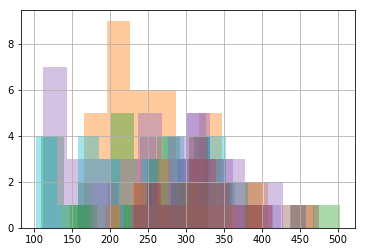

In [252]:
for hour in combined3['hour'].unique():
    combined3[combined3['hour']== hour].number_of_likes.hist(alpha=.4)

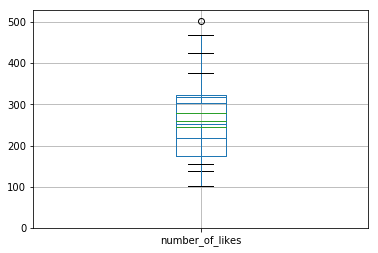

In [261]:
combined3[combined3['hour']< 4].number_of_likes.hist(alpha=.4)
combined3[(combined3['hour']> 10)&(combined3['hour']<16)].boxplot(column='number_of_likes')
combined3[(combined3['hour']> 15)&(combined3['hour']<19)].boxplot(column='number_of_likes')
combined3[(combined3['hour']> 18)&(combined3['hour']<24)].boxplot(column='number_of_likes')

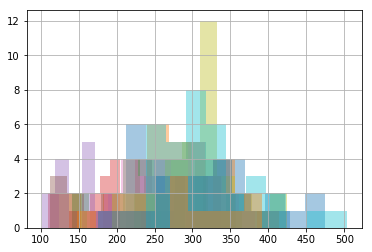

In [262]:
for month in combined3['month'].unique():
    combined3[combined3['month']== month].number_of_likes.hist(alpha=.4)

In [265]:
print(combined3[combined3['butt_pic']==True].number_of_likes.mean())
print(combined3[combined3['butt_pic']==True].number_of_likes.std())

317.41379310344826
73.47668106344028


In [266]:
print(combined3[combined3['pro\\model']==True].number_of_likes.mean())
print(combined3[combined3['pro\\model']==True].number_of_likes.std())

298.3783783783784
81.29280115434281
